In [1]:
%load_ext autoreload
%autoreload 2
import gc
import re
import pandas as pd
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import os
import sys
HOME = os.path.expanduser("~")
sys.path.append(f'{HOME}/kaggle/data_analysis/library')
import utils
from utils import get_categorical_features, get_numeric_features, reduce_mem_usage
from preprocessing import get_dummies
import datetime

from tqdm import tqdm
import time
import sys

os.listdir('../input/')
key = 'card_id'
target = 'target'
ignore_list = [key, target, 'merchant_id', 'first_avtive_month']
start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())

In [2]:
import glob
from joblib import Parallel, delayed

path_list = glob.glob('../stack/*stack*.gz')
base = utils.read_df_pkl('../input/base_first*0*').set_index(key)
base['first_active_month'].fillna('2017-03', inplace=True)

def concat_stack(path):
    tmp = utils.read_pkl_gzip(path).set_index(key)
    date = re.search(r'/([^/.]*)_stack', path).group(1)
    cv = re.search(r'CV([^/.]*)', path).group(1)
    if 'pred_mean' in tmp.columns:
        tmp = tmp['pred_mean']
        tmp.name =  f"{date}_{cv}"
    else:
        tmp = tmp['prediction']
        tmp.name =  f"{date}_{cv}"
    return tmp

# pred_list = Parallel(n_jobs=-1)([delayed(concat_stack)(path) for path in path_list])
pred_list = Parallel(n_jobs=-1)([delayed(concat_stack)(path) for path in path_list if path.count('3-6389228323052527')])
df_pred = pd.concat(pred_list, axis=1)
base = base.join(df_pred)

100%|██████████| 3/3 [00:00<00:00, 68.03it/s]


In [4]:
pd.set_option('max_rows', 200)
from sklearn.metrics import mean_squared_error
#========================================================================
# Part of card_id Score


pred_cols = [col for col in base.columns if col not in ignore_list and col.count('LB')]

pred_col_1 = pred_cols[:150]
# pred_col_2 = pred_cols[150:]

base_train = base[~base[target].isnull()].reset_index().fillna(0)
month_list = sorted(np.unique(list(base['first_active_month'].value_counts().index)))

def get_fam_score(pred_col):
# fam_score_list = []
# for pred_col in tqdm(pred_cols):

    base_train = base[~base[target].isnull()].reset_index().fillna(0)
    part_score_list = []
    part_N_list = []
    fam_list = []
    score_list = []
    
    for fam in month_list:
        df_part = base_train[base_train['first_active_month']==fam]
        if len(df_part)==0:
            continue
        part_id_list = df_part[key].values
    
        part_train = base_train.loc[base_train[key].isin(part_id_list), :]
        y_train = part_train[target].values
        
        y_pred = part_train[pred_col].values
        # RMSE
        part_score = np.sqrt(mean_squared_error(y_train, y_pred))

        fam_list.append(fam)
        part_score_list.append(part_score)
        part_N_list.append(len(part_id_list))
    
    df = pd.DataFrame(np.asarray([fam_list, part_score_list, part_N_list]).T)
    df.columns = ['FAM', 'CV', 'N']
    df['name'] = pred_col
#     print(df['FAM'].value_counts())
#     fam_score_list.append(df)
    return df
    
fam_score_list_1 = Parallel(n_jobs=-1)([delayed(get_fam_score)(pred_col) for pred_col in pred_col_1])
# fam_score_list_2 = Parallel(n_jobs=-1)([delayed(get_fam_score)(pred_col) for pred_col in pred_col_2])

In [10]:
viz_list = []
for fam_score_list in [fam_score_list_1]:
    result = pd.concat(fam_score_list, axis=0)
    result['yyyymm'] = result['FAM'].map(lambda x: int(x.replace('-', '')))
    result['CV'] = result['CV'].astype('float64')
#     result = result[result['name']!='0109_223_1-5465657344282366_LB']
    result.sort_values(by=['FAM', 'CV'], ascending=True, inplace=True)
    
    viz_list.append(result.copy())
#     viz_fam_min = '2012-01'
df_row = pd.concat(viz_list, axis=0)
bench = df_row[df_row['name']=='0129_102_3-6389228323052527_LB']
bench['row_no'] = 'bench'
bench.to_csv('../input/bench_LB3684_FAM_cv_score.csv', index=False)

In [11]:
bench.head()

,FAM,CV,N,name,yyyymm,row_no
0,2011-11,0.852257,8,0129_102_3-6389228323052527_LB,201111,bench
1,2011-12,0.522976,2,0129_102_3-6389228323052527_LB,201112,bench
2,2012-02,1.079620,7,0129_102_3-6389228323052527_LB,201202,bench
3,2012-03,2.021541,10,0129_102_3-6389228323052527_LB,201203,bench
4,2012-04,12.924885,18,0129_102_3-6389228323052527_LB,201204,bench


In [129]:
viz_list = []
for fam_score_list in [fam_score_list_1, fam_score_list_2]:
    result = pd.concat(fam_score_list, axis=0)
    result['yyyymm'] = result['FAM'].map(lambda x: int(x.replace('-', '')))
    result['CV'] = result['CV'].astype('float64')
#     result = result[result['name']!='0109_223_1-5465657344282366_LB']
    result.sort_values(by=['FAM', 'CV'], ascending=True, inplace=True)
    
    viz_list.append(result.copy())
#     viz_fam_min = '2012-01'
df_row = pd.concat(viz_list, axis=0)
df_row = utils.row_number(df=result, level='FAM')
viz = df_row[df_row['row_no']<=25]
    
bench = df_row[df_row['name']=='0129_102_3-6389228323052527_LB']
bench = bench[bench['FAM']>=viz_fam_min]
bench['row_no'] = 'bench'
viz = pd.concat([bench, viz], axis=0, ignore_index=True)

bench.rename(columns={'CV':'bench', 'name':'bench_name'}, inplace=True)
viz = viz.merge(bench[['FAM', 'yyyymm', 'bench']], how='inner', on=['FAM', 'yyyymm'])
viz['diff'] = viz['CV'] - viz['bench']

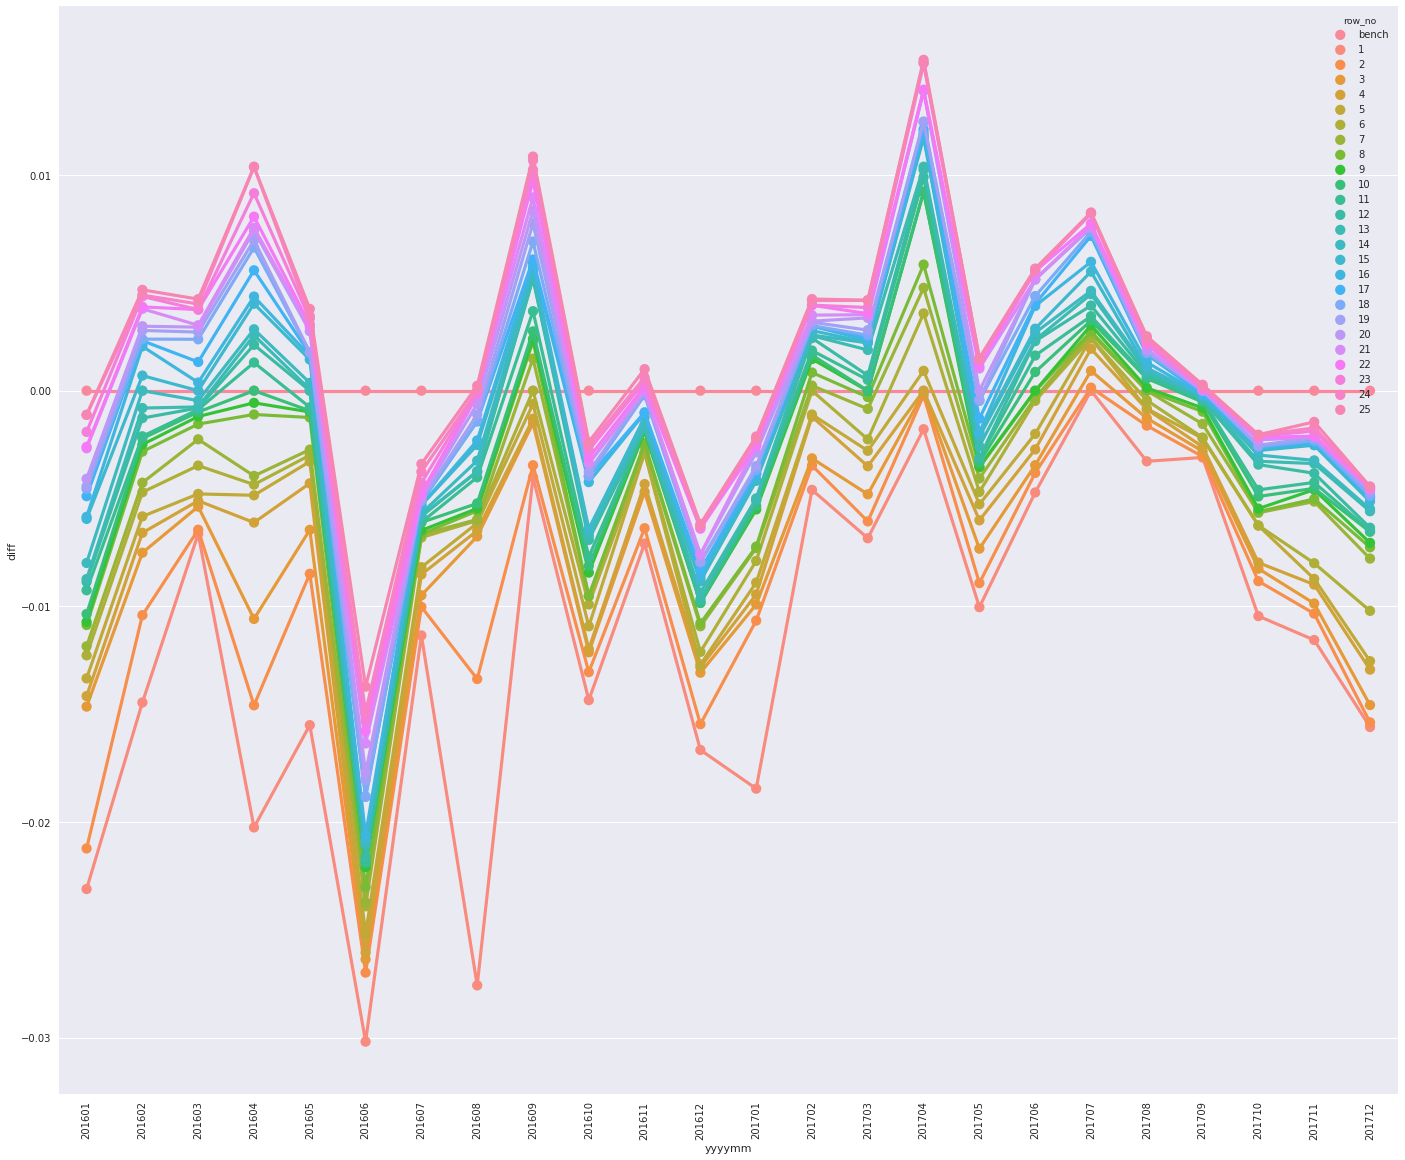

In [130]:
plt.figure(figsize=(24, 20))
tmp_viz = viz[viz['yyyymm']<201801]
sns.pointplot(x="yyyymm", y="diff", hue="row_no", data=tmp_viz[tmp_viz['yyyymm']>=201601])
plt.xticks(rotation=90)
plt.show()

# viz_N = viz[['yyyymm', 'N']].drop_duplicates()
# viz_N['N'] = viz_N['N'].astype('int')
# sns.color_palette(n_colors=24)
# plt.figure(figsize=(24, 4))
# sns.pointplot(x="yyyymm", y="N", data=viz_N[viz_N['yyyymm']>=201601])
# plt.xticks(rotation=90)
# plt.show()

### Stacking

In [144]:
fam_list = sorted(np.unique(base['first_active_month'].values).tolist())
df_stack = pd.DataFrame()
base_train = base[~base[target].isnull()]

top = df_row[df_row['row_no']<=25]

#========================================================================
# Bench
bench = df_row[df_row['name']=='0129_102_3-6389228323052527_LB']
top = pd.concat([top, bench], axis=0)
bench['row_no'] = 'bench'
bench.rename(columns={'CV':'bench', 'name':'bench_name'}, inplace=True)
top = top.merge(bench[['FAM', 'yyyymm', 'bench']], how='inner', on=['FAM', 'yyyymm'])
top['diff'] = top['CV'] - top['bench']
top = top[top['diff']<=0.0]
#========================================================================

all_stack_col_list = []
stack_list = []

#========================================================================
# FAM別に予測値をstackしてAveraging
# 2012-01の為のstackがなくなるという現象が起きるので、個別にベストCVを選ぶ
id_201201 = base[base['first_active_month']=='2012-01'].index
special_201201_cols = []
for col in base.loc[id_201201, :].columns:
    if col.count('3-63'):
        special_201201_cols.append(col)

for fam in fam_list:
    stack_cols = top[top['FAM']==fam]['name'].values.tolist()
    
    if fam== '2012-01':
        stack_cols = special_201201_cols
             
    if fam>='2016-01':
        all_stack_col_list += stack_cols

    # 対象FAMに絞る
    df_fam = base[['first_active_month'] + stack_cols]
    df_fam = df_fam[df_fam['first_active_month']==fam][stack_cols]
    df_fam['blend'] = df_fam[stack_cols].mean(axis=1)
    df_stack = df_fam['blend']
    
    stack_list.append(df_stack.copy())

df_stack = pd.concat(stack_list, axis=0)
print(df_stack.shape)
#========================================================================


#========================================================================
# Nullがないかチェック
# null_id = df_stack[df_stack.isnull()].index
# display( base_train.loc[null_id, :])
# sys.exit()
#========================================================================

#========================================================================
# Blend CV Score
df_stack = df_stack.to_frame()
base_train = base[~base[target].isnull()]
part_train = base_train[target].to_frame().join(df_stack['blend'], how='inner').dropna()
y_train = part_train[target].values
y_pred = part_train['blend'].values
cv_score = np.sqrt(mean_squared_error(y_train, y_pred))
print(cv_score)
#========================================================================

submit = pd.read_csv('../input/sample_submission.csv').set_index(key)
submit[target] = df_stack['blend']
submit_path = f'../submit/{start_time[4:12]}_submit_blender_top_FAM_model_CV{cv_score}_LB.csv'
display(submit.head())
# submit.to_csv(submit_path, index=True)

(325540,)
3.622624779504783


,target
card_id,
C_ID_0ab67a22ab,-2.056652
C_ID_130fd0cbdd,-0.539980
C_ID_b709037bc5,-1.193258
C_ID_d27d835a9f,-0.128041
C_ID_2b5e3df5c2,-0.957183


In [147]:
all_stack_col_list = sorted(list(set(all_stack_col_list)))
for col  in all_stack_col_list:
    print(col)

0107_093_3-651062157929207_LB
0107_224_3-650261064674953_LB
0107_230_3-650364771975287_LB
0107_234_3-649581997004075_LB
0108_014_3-649821386872066_LB
0108_200_3-6497477447061173_LB
0108_230_3-653391743289176_LB
0108_231_3-649900399084428_LB
0108_232_3-64884592382666_LB
0109_032_3-6495361065070235_LB
0109_075_3-649767935786786_LB
0109_191_4-09782224622231_LB
0109_215_3-5317518544372155_LB
0110_083_3-6662646410644384_LB
0110_084_3-6481742957158105_LB
0110_211_3-665719872930981_LB
0110_211_3-666769302305775_LB
0110_220_3-6527566399693425_LB
0110_220_3-6538134540799314_LB
0110_221_3-653950949854275_LB
0110_231_3-6489421450842876_LB
0111_093_3-6498127628201233_LB
0111_095_3-6494247953281826_LB
0111_154_3-3530444409955336_LB
0112_085_3-649268944881051_LB
0112_094_3-6487122266075667_LB
0112_123_3-649256498211181_LB
0112_123_3-649256498211181_LB3
0112_161_3-649133141540562_LB
0112_163_3-3503452476449724_LB
0112_174_3-3502356217151985_LB
0113_105_3-6487922531099897_LB
0113_230_3-649593959564725